# script to get the reconstructed t 

Processing setting: 5x41
❌ Failed to read /home/ubuntu/meson-structure/data/csv_files_kaon/reco_ff_lamda/k_lambda_5x41_5000evt_001.reco_ff_lambda.csv: No columns to parse from file
❌ Failed to read /home/ubuntu/meson-structure/data/csv_files_kaon/reco_ff_lamda/k_lambda_5x41_5000evt_002.reco_ff_lambda.csv: No columns to parse from file
❌ Failed to read /home/ubuntu/meson-structure/data/csv_files_kaon/reco_ff_lamda/k_lambda_5x41_5000evt_003.reco_ff_lambda.csv: No columns to parse from file
❌ Failed to read /home/ubuntu/meson-structure/data/csv_files_kaon/reco_ff_lamda/k_lambda_5x41_5000evt_004.reco_ff_lambda.csv: No columns to parse from file
❌ Failed to read /home/ubuntu/meson-structure/data/csv_files_kaon/reco_ff_lamda/k_lambda_5x41_5000evt_005.reco_ff_lambda.csv: No columns to parse from file
❌ Failed to read /home/ubuntu/meson-structure/data/csv_files_kaon/reco_ff_lamda/k_lambda_5x41_5000evt_006.reco_ff_lambda.csv: No columns to parse from file
❌ Failed to read /home/ubuntu/meson-str

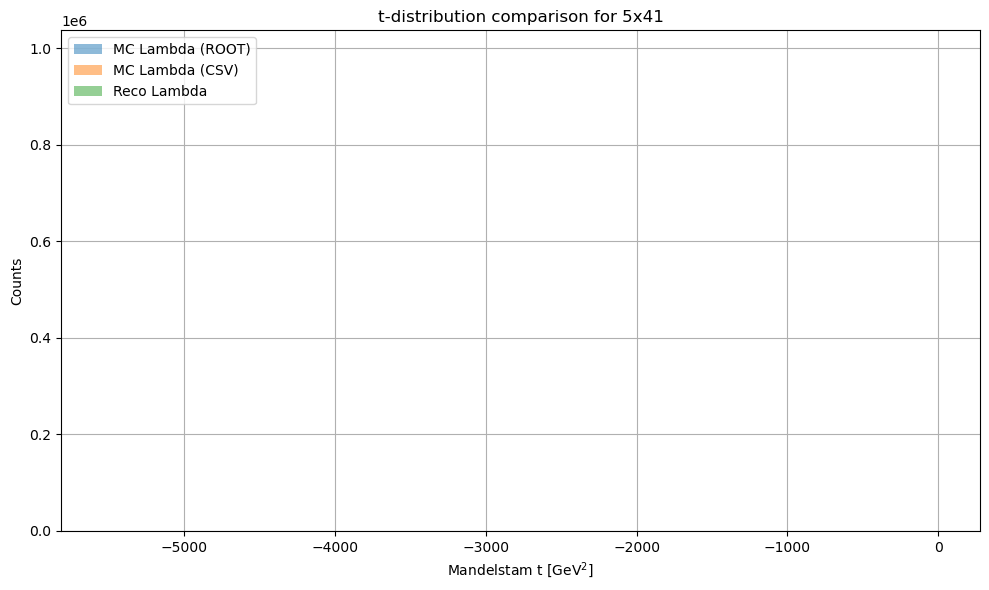

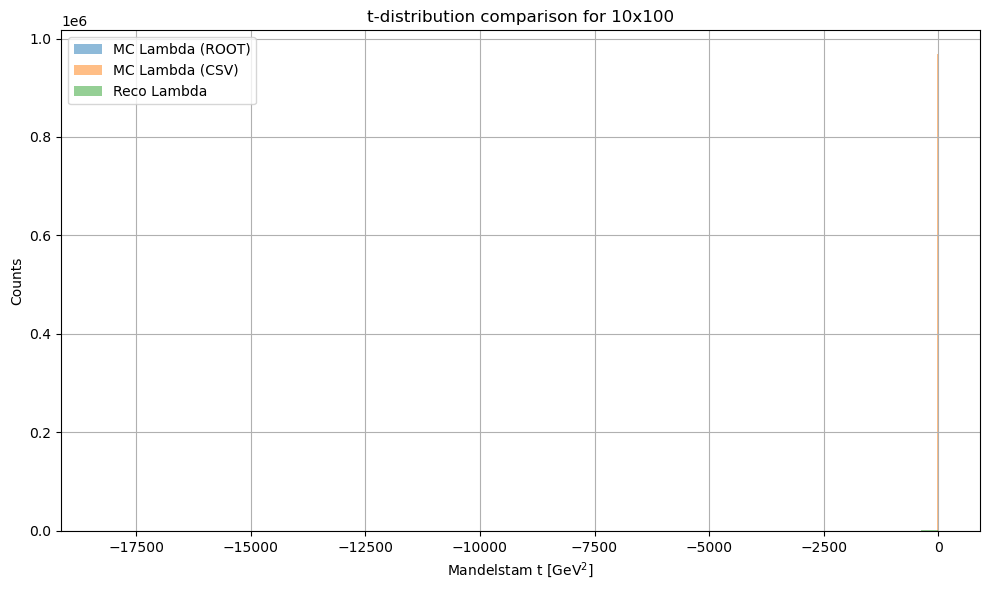

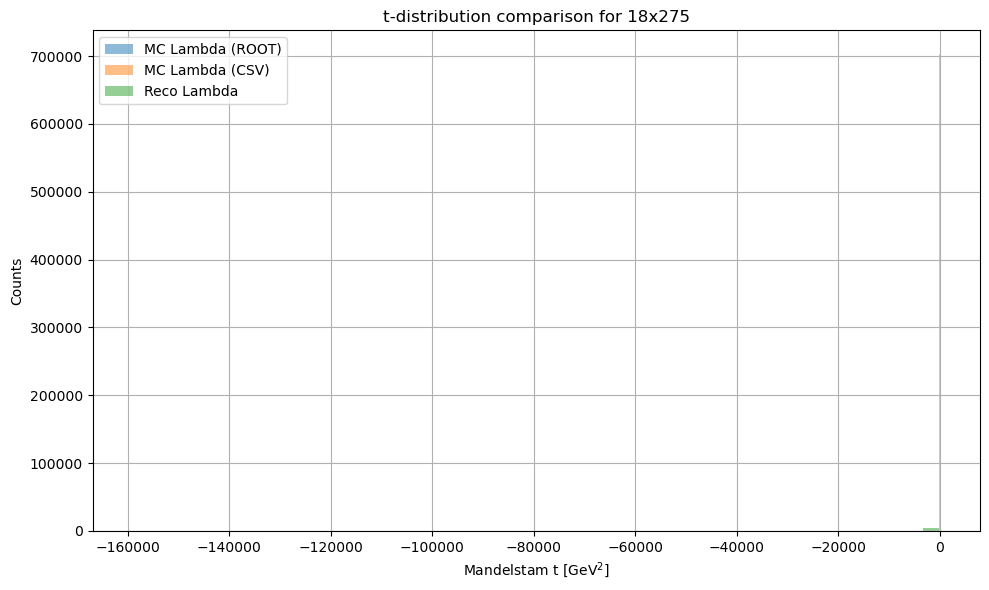

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
import os
import zipfile
from glob import glob
import re  # Needed for extracting segment numbers

# === Paths ===
settings = ["5x41", "10x100", "18x275"]
base_csv_dir = "/home/ubuntu/meson-structure/data/csv_files_kaon/kaon_all/meson-strcutrue-2025-06-05-csv"
reco_lambda_dir = "/home/ubuntu/meson-structure/data/csv_files_kaon/reco_ff_lamda"
root_dir = "/home/ubuntu/meson-structure/data/root_files"

# Mapping between setting and corresponding ROOT file
root_file_map = {
    "5x41": "k_lambda_crossing_25_5.0on41.0_x0.0001-0.9000_q1.0-500.0.root",
    "10x100": "k_lambda_crossing_25_10.0on100.0_x0.0001-0.9000_q1.0-500.0.root",
    "18x275": "k_lambda_crossing_25_18.0on275.0_x0.0001-0.9000_q1.0-500.0.root"
}

mass_lambda = 1.1156
mass_proton = 0.93827203


# === Helper Functions ===
def mandelstam_t(p_proton, p_lambda):
    q = p_proton - p_lambda
    return q[0]**2 - np.sum(q[1:]**2)

def get_four_vector(df, energy_col, px_col, py_col, pz_col, mass=None):
    px = df[px_col].to_numpy()
    py = df[py_col].to_numpy()
    pz = df[pz_col].to_numpy()

    if energy_col in df.columns:
        E = df[energy_col].to_numpy()
    elif mass is not None:
        E = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
        px = -1*px # this is from the observation that mcpart_lambda values look -ve of the rootfile values
    else:
        raise ValueError(f"Energy column '{energy_col}' not found and no mass provided.")
    
    return np.vstack((E, px, py, pz)).T

# Safe t calculator
def safe_t_calc(pvecs, lvecs):
    if lvecs is None or len(lvecs) != n_events:
        return np.full(n_events, np.nan)
    return np.array([mandelstam_t(p, l) for p, l in zip(pvecs, lvecs)])

def safe_t_calc_indexed(pvecs, lvecs, indices, total_events):
    """Handles sparse lvecs and aligns with total event count."""
    t_vals = np.full(total_events, np.nan)
    if lvecs is not None and indices is not None and len(lvecs) == len(indices):
        for i, idx in enumerate(indices):
            if idx < total_events:
                t_vals[idx] = mandelstam_t(pvecs[idx], lvecs[i])
    return t_vals

def read_csv_zip(filepath):
    with zipfile.ZipFile(filepath) as z:
        for name in z.namelist():
            with z.open(name) as f:
                return pd.read_csv(f)
            
# Fill NaNs for missing 4-vectors to keep array shape consistent
def pad_vector_array(vec, name):
    if vec is None or len(vec) != n_events:
        return np.full((n_events, 4), np.nan)
    return vec

def pad_vector_array_indexed(vec, indices, total_events):
    padded = np.full((total_events, 4), np.nan)
    if vec is not None and indices is not None and len(vec) == len(indices):
        for i, idx in enumerate(indices):
            if idx < total_events:
                padded[idx] = vec[i]
    return padded

# === Main Processing ===
all_results = []

for setting in settings:
    print(f"Processing setting: {setting}")
    
    # Get files
    csv_pattern = f"k_lambda_{setting}_5000evt_*.csv.zip"
    reco_dis_files = glob(os.path.join(base_csv_dir, csv_pattern))
    mcpart_files = [f for f in reco_dis_files if "mcpart_lambda" in f]
    reco_ff_files = [f for f in reco_dis_files if "reco_dis" in f]  # Optional
    # Resolve ROOT file
    root_file = os.path.join(root_dir, root_file_map[setting])
    # Read and combine all non-empty reco_ff_lambda segment files
    reco_ff_lambda_pattern = f"k_lambda_{setting}_5000evt_*.reco_ff_lambda.csv"
    reco_ff_lambda_files = sorted(glob(os.path.join(reco_lambda_dir, reco_ff_lambda_pattern)))

    df_reco_ff_list = []
    for fpath in reco_ff_lambda_files:
        try:
            df = pd.read_csv(fpath)
            if df.empty:
                print(f"⚠️ Empty reco_ff_lambda file skipped: {fpath}")
                continue

            # Extract segment number from filename
            match = re.search(r"5000evt_(\d+)\.reco_ff_lambda\.csv", os.path.basename(fpath))
            if not match:
                print(f"❌ Couldn't extract segment number from {fpath}")
                continue
            segment = int(match.group(1))

            # Compute global event number
            df["global_event"] = (segment - 1) * 5000 + df["event"]
            df_reco_ff_list.append(df)
        except Exception as e:
            print(f"❌ Failed to read {fpath}: {e}")

    if not df_reco_ff_list:
        print(f"🚫 No usable reco_ff_lambda data for setting {setting}. Skipping reco t.")
        lam_reco = None
        reco_event_ids = None
    else:
        df_reco_ff = pd.concat(df_reco_ff_list, ignore_index=True)
        lam_reco = get_four_vector(df_reco_ff, "lam_energy", "lam_px", "lam_py", "lam_pz")
        reco_event_ids = df_reco_ff["global_event"].to_numpy()

    df_mcpart_list = []
    for fpath in mcpart_files:
        try:
            df = read_csv_zip(fpath)
            if df.empty:
                print(f"⚠️ Empty mcpart file skipped: {fpath}")
                continue

            # Extract segment number from filename
            match = re.search(r"5000evt_(\d+)\.mcpart_lambda\.csv\.zip", os.path.basename(fpath))
            if not match:
                print(f"❌ Couldn't extract segment number from {fpath}")
                continue
            segment = int(match.group(1))

            # Compute global event number
            df["global_event"] = (segment - 1) * 5000 + df["event"]
            df_mcpart_list.append(df)
        except Exception as e:
            print(f"❌ Failed to read {fpath}: {e}")

    if not df_mcpart_list:
        print(f"🚫 No usable mcpart_lambda data for setting {setting}. Skipping reco t.")
        lam_reco = None
        mc_event_ids = None
    else:
        df_mcpart = pd.concat(df_mcpart_list, ignore_index=True)
        lam_mc = get_four_vector(df_mcpart, "lam_energy", "lam_px", "lam_py", "lam_pz", mass_lambda)
        mc_event_ids = df_mcpart["global_event"].to_numpy()

    # Proton 4-vector (from ROOT)
    with uproot.open(root_file) as f:
        tree = f["Process"]
        Epr = tree["EprE_inc"].array(library="np")
        px = tree["pprx_inc"].array(library="np")
        py = tree["ppry_inc"].array(library="np")
        pz = tree["pprz_inc"].array(library="np")
        p_proton = np.vstack((Epr, px, py, pz)).T

        # MC Lambda from root
        # Correct Lambda energy assuming momentum is correct but mass was wrongly set to proton mass
        El_raw = tree["ElambE_Lab"].array(library="np")
        El = np.sqrt(El_raw**2 - mass_proton**2 + mass_lambda**2)
        plx = tree["plambx_Lab"].array(library="np")
        ply = tree["plamby_Lab"].array(library="np")
        plz = tree["plambz_Lab"].array(library="np")
        lam_mc_root = np.vstack((El, plx, ply, plz)).T

        # exact t value
        tdis_t = tree["TDIS_t"].array(library="np")

    n_events = len(p_proton)

    # Compute t values
    t_reco = safe_t_calc_indexed(p_proton, lam_reco, reco_event_ids, n_events)
    t_mc_csv = safe_t_calc_indexed(p_proton, lam_mc, mc_event_ids, n_events)
    t_mc_root = safe_t_calc(p_proton, lam_mc_root)

    lam_reco_padded = pad_vector_array_indexed(lam_reco, reco_event_ids, n_events)
    lam_mc_padded = pad_vector_array_indexed(lam_mc, mc_event_ids, n_events)
    lam_mc_root_padded = pad_vector_array(lam_mc_root, "lam_mc_root")

    # Build DataFrame
    df_out = pd.DataFrame({
        "global_event": np.arange(n_events),
        "event": np.arange(n_events),
        "setting": [setting] * n_events,
        "t_reco": t_reco,
        "t_mc_csv": t_mc_csv,
        "t_mc_root": t_mc_root,
        "t_mc_generator_value": tdis_t,
        # Proton 4-vector
        "E_proton": p_proton[:, 0],
        "px_proton": p_proton[:, 1],
        "py_proton": p_proton[:, 2],
        "pz_proton": p_proton[:, 3],
        # Reco Lambda 4-vector
        "E_lam_reco": lam_reco_padded[:, 0],
        "px_lam_reco": lam_reco_padded[:, 1],
        "py_lam_reco": lam_reco_padded[:, 2],
        "pz_lam_reco": lam_reco_padded[:, 3],
        # MC Lambda (CSV)
        "E_lam_mc_csv": lam_mc_padded[:, 0],
        "px_lam_mc_csv": lam_mc_padded[:, 1],
        "py_lam_mc_csv": lam_mc_padded[:, 2],
        "pz_lam_mc_csv": lam_mc_padded[:, 3],
        # MC Lambda (ROOT)
        "E_lam_mc_root": lam_mc_root_padded[:, 0],
        "px_lam_mc_root": lam_mc_root_padded[:, 1],
        "py_lam_mc_root": lam_mc_root_padded[:, 2],
        "pz_lam_mc_root": lam_mc_root_padded[:, 3],
    })

    df_out.to_csv(f"mandelstam_t_{setting}.csv", index=False)
    all_results.append(df_out)



# Combine and Save
result_df = pd.concat(all_results, ignore_index=True)
result_df.to_csv("mandelstam_t_analysis_lambda.csv", index=False)

# === Plotting Diagnostics ===
for setting in settings:
    subset = result_df[result_df["setting"] == setting]
    plt.figure(figsize=(10, 6))

    # Drop NaNs before plotting
    t_mc_root_vals = subset["t_mc_root"].dropna()
    t_mc_csv_vals = subset["t_mc_csv"].dropna()
    t_reco_vals = subset["t_reco"].dropna()

    if len(t_mc_root_vals) > 0:
        plt.hist(t_mc_root_vals, bins=50, alpha=0.5, label="MC Lambda (ROOT)")
    else:
        print(f"⚠️ Skipping t_mc_root plot for {setting}: all values are NaN")

    if len(t_mc_csv_vals) > 0:
        plt.hist(t_mc_csv_vals, bins=50, alpha=0.5, label="MC Lambda (CSV)")
    else:
        print(f"⚠️ Skipping t_mc_csv plot for {setting}: all values are NaN")

    if len(t_reco_vals) > 0:
        plt.hist(t_reco_vals, bins=50, alpha=0.5, label="Reco Lambda")
    else:
        print(f"⚠️ Skipping t_reco plot for {setting}: all values are NaN")

    plt.xlabel("Mandelstam t [GeV$^2$]")
    plt.ylabel("Counts")
    plt.title(f"t-distribution comparison for {setting}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"t_dist_{setting}.png")
    plt.show()
    plt.close()



In [31]:
for setting in settings:
    subset = result_df[result_df["setting"] == setting]
    print(f"{setting} → Events: {len(subset)}, "
          f"Valid t_reco: {subset['t_reco'].notna().sum()}, "
          f"t_mc_csv: {subset['t_mc_csv'].notna().sum()}, "
          f"t_mc_root: {subset['t_mc_root'].notna().sum()}")


5x41 → Events: 1000000, Valid t_reco: 22, t_mc_csv: 991771, t_mc_root: 1000000
10x100 → Events: 1000000, Valid t_reco: 1666, t_mc_csv: 971514, t_mc_root: 1000000
18x275 → Events: 1000000, Valid t_reco: 4552, t_mc_csv: 705000, t_mc_root: 1000000


In [25]:
result_df.head()

,global_event,event,setting,t_reco,t_mc_csv,t_mc_root,t_mc_generator_value,E_proton,px_proton,py_proton,...,py_lam_reco,pz_lam_reco,E_lam_mc_csv,px_lam_mc_csv,py_lam_mc_csv,pz_lam_mc_csv,E_lam_mc_root,px_lam_mc_root,py_lam_mc_root,pz_lam_mc_root
0,0,0,5x41,NaN,-4.288600,-0.016657,-0.016657,41.003267,1.051396,-0.004610,...,NaN,NaN,40.396460,-1.017362,-0.067050,40.368179,39.656806,1.049991,-0.049908,39.627171
1,1,1,5x41,NaN,-4.063532,-0.033157,-0.033157,41.028670,1.032687,-0.008288,...,NaN,NaN,37.944278,-0.974104,0.055562,37.915323,40.565445,0.986925,0.157268,40.537785
2,2,2,5x41,NaN,-4.276639,-0.028641,-0.028641,41.008448,1.002129,-0.018060,...,NaN,NaN,40.025171,-1.062590,-0.037290,39.995491,39.684697,0.968957,-0.140000,39.656930
3,3,3,5x41,NaN,-4.875065,-0.042038,-0.042038,41.018906,1.009852,0.018937,...,NaN,NaN,40.615145,-1.193958,-0.082455,40.582177,38.326958,0.879577,0.104101,38.300479
4,4,4,5x41,NaN,-4.808716,-0.027353,-0.027353,40.997790,1.036391,0.007724,...,NaN,NaN,40.126802,-1.152816,0.048011,40.094693,39.332678,0.926444,0.080747,39.305855


In [44]:
# print(result_df["t_mc_csv"].dropna().to_string(index=True))
# print(result_df.loc[459])
# print(result_df[~pd.isna(result_df["t_reco"])])
import pandas as pd

# Correct way to filter out NaNs
filtered_df = result_df[result_df["t_reco"].notna()]
filtered_df = filtered_df.reset_index(drop=True)
print(filtered_df.loc[3])




global_event                 244510
event                        244510
setting                        5x41
t_reco                 -3309.253504
t_mc_csv                  -0.027007
t_mc_root                 -0.033309
t_mc_generator_value      -0.033309
E_proton                  41.008278
px_proton                  1.011049
py_proton                  0.007005
pz_proton                 40.985074
E_lam_reco                41.843082
px_lam_reco               19.957071
py_lam_reco              -36.746414
pz_lam_reco                0.982763
E_lam_mc_csv              40.551927
px_lam_mc_csv              0.857483
py_lam_mc_csv              0.054772
pz_lam_mc_csv             40.527471
E_lam_mc_root             39.462851
px_lam_mc_root             0.851947
py_lam_mc_root            -0.042551
pz_lam_mc_root            39.437855
Name: 3, dtype: object


In [ ]:
# print(result_df[result_df["px_lam_mc_csv"] == -1.09526

Empty DataFrame
Columns: [global_event, event, setting, t_reco, t_mc_csv, t_mc_root, t_mc_generator_value, E_proton, px_proton, py_proton, pz_proton, E_lam_reco, px_lam_reco, py_lam_reco, pz_lam_reco, E_lam_mc_csv, px_lam_mc_csv, py_lam_mc_csv, pz_lam_mc_csv, E_lam_mc_root, px_lam_mc_root, py_lam_mc_root, pz_lam_mc_root]
Index: []

[0 rows x 23 columns]


In [6]:
print(df_reco_ff[["event", "global_event"]].head())
print(df_mcpart[["event", "global_event"]].head())


   event  global_event
0    275           275
1    375           375
2    607           607
3    708           708
4    735           735
   event  global_event
0      0        820000
1      1        820001
2      2        820002
3      3        820003
4      4        820004


In [7]:
print(df_mcpart[["event", "global_event"]])

        event  global_event
0           0        820000
1           1        820001
2           2        820002
3           3        820003
4           4        820004
...       ...           ...
707141   4995        814995
707142   4996        814996
707143   4997        814997
707144   4998        814998
707145   4999        814999

[707146 rows x 2 columns]


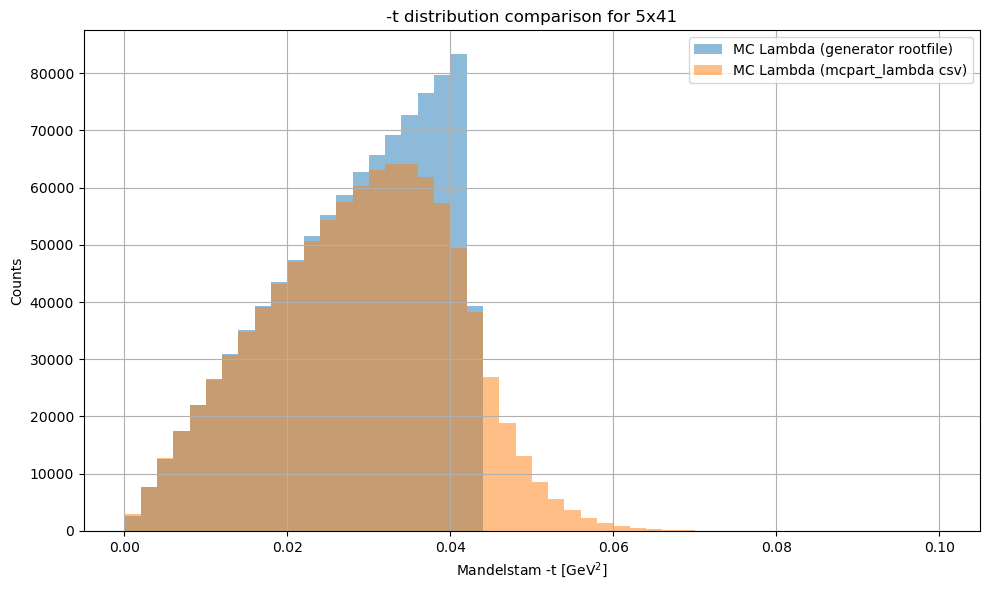

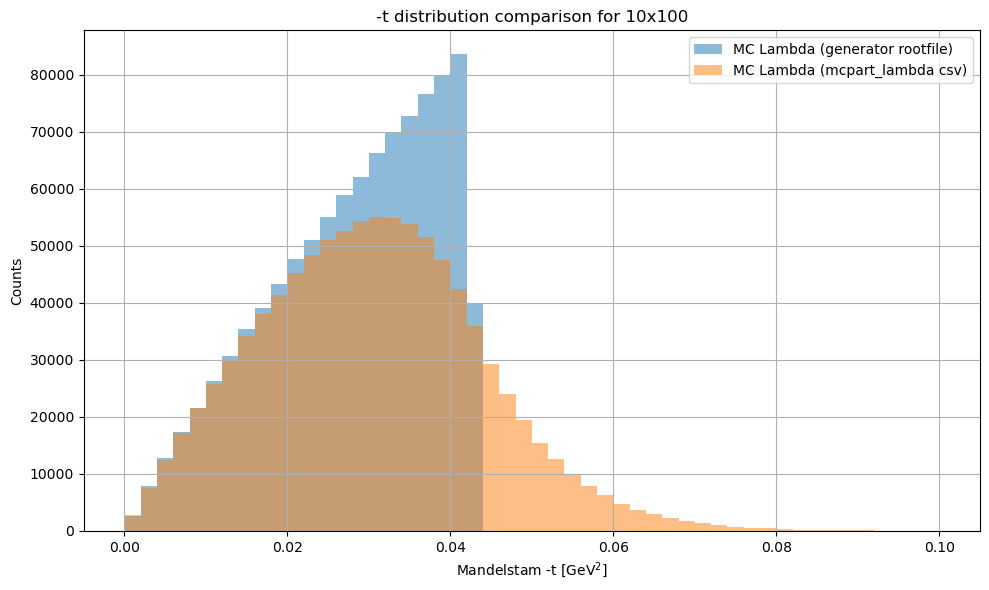

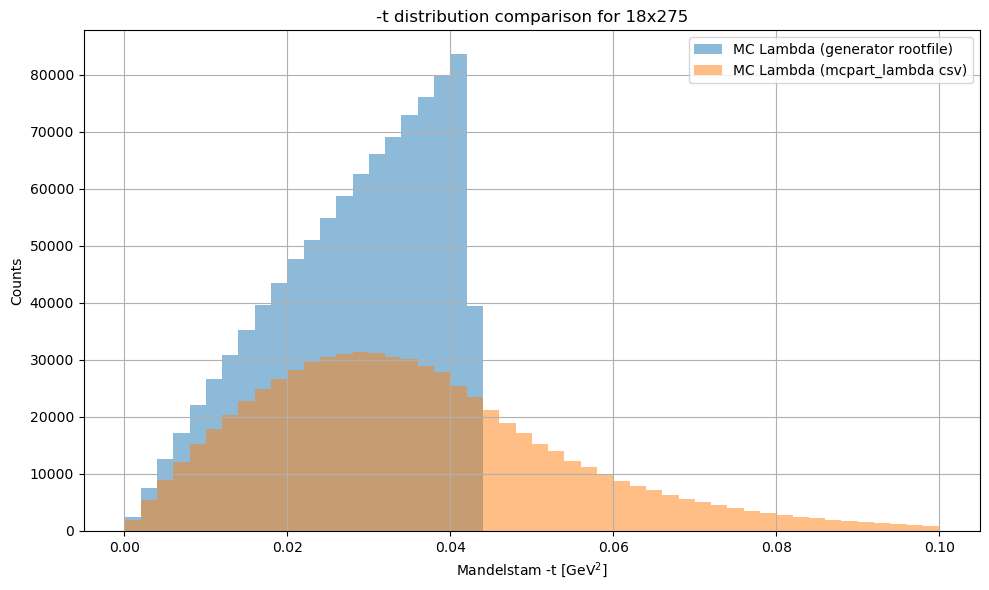

In [68]:
# === Plotting Diagnostics ===
for setting in settings:
    subset = result_df[result_df["setting"] == setting]
    plt.figure(figsize=(10, 6))

    # Drop NaNs before plotting
    t_mc_root_vals = subset["t_mc_root"].dropna()
    t_mc_csv_vals = subset["t_mc_csv"].dropna()
    t_reco_vals = subset["t_reco"].dropna()

    t_range = (0, 0.1)

    if len(t_mc_root_vals) > 0:
        plt.hist(-t_mc_root_vals, bins=50, range=t_range, alpha=0.5, label="MC Lambda (generator rootfile)")
    else:
        print(f"⚠️ Skipping t_mc_root plot for {setting}: all values are NaN")

    if len(t_mc_csv_vals) > 0:
        plt.hist(-t_mc_csv_vals, bins=50, range=t_range, alpha=0.5, label="MC Lambda (mcpart_lambda csv)")
    else:
        print(f"⚠️ Skipping t_mc_csv plot for {setting}: all values are NaN")

    # if len(t_reco_vals) > 0:
    #     plt.hist(t_reco_vals, bins=50, range=t_range, alpha=0.5, label="Reco Lambda")
    # else:
    #     print(f"⚠️ Skipping t_reco plot for {setting}: all values are NaN")

    plt.xlabel("Mandelstam -t [GeV$^2$]")
    plt.ylabel("Counts")
    plt.title(f"-t distribution comparison for {setting}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"t_mcpart_hist_{setting}.png")
    plt.show()
    plt.close()

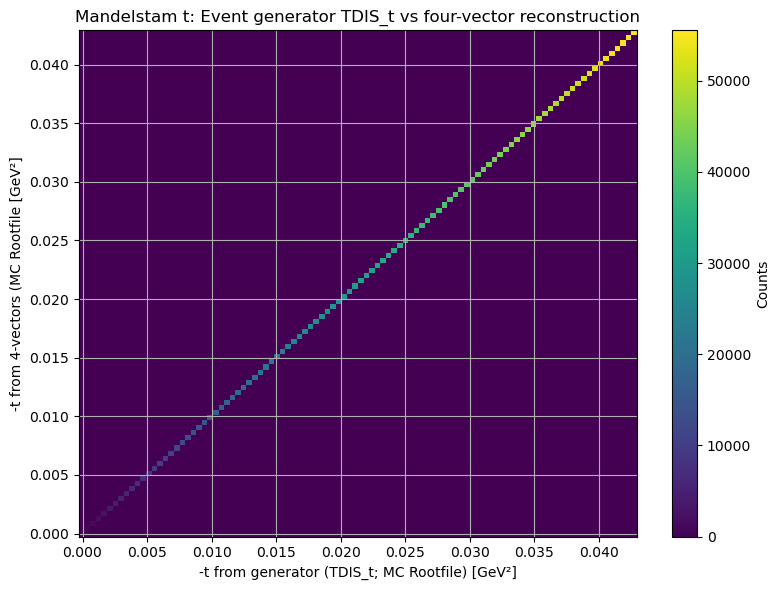

In [67]:
import matplotlib.pyplot as plt

# Drop rows where either x or y is NaN
subset = result_df[["t_mc_generator_value", "t_mc_root"]].dropna()

x = subset["t_mc_generator_value"]
y = subset["t_mc_root"]

plt.figure(figsize=(8, 6))
plt.hist2d(-x, -y, bins=100, cmap='viridis')
plt.colorbar(label="Counts")
plt.xlabel("-t from generator (TDIS_t; MC Rootfile) [GeV²]")
plt.ylabel("-t from 4-vectors (MC Rootfile [GeV²]")
plt.title("Mandelstam t: Event generator TDIS_t vs four-vector reconstruction")
plt.grid(True)
plt.tight_layout()
plt.savefig("t_gen_vs_root.png")
plt.show()


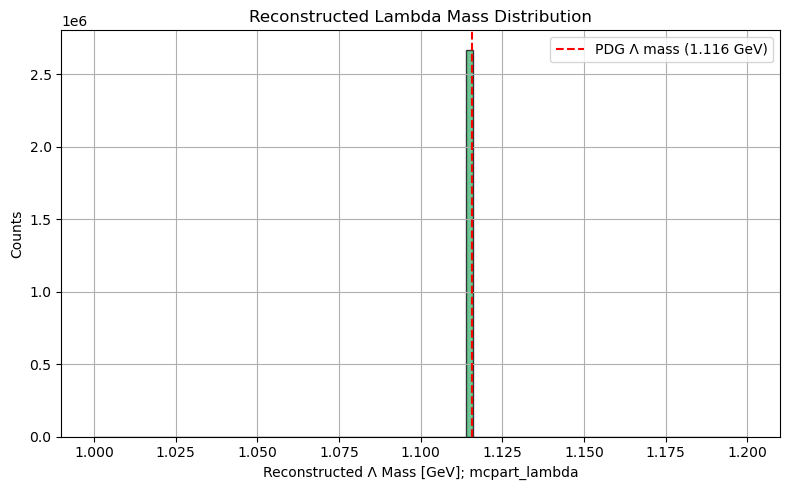

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute Reconstructed Lambda Mass (from 4-vector components) ---
# Formula: m² = E² - px² - py² - pz²
E = result_df["E_lam_mc_csv"]
px = result_df["px_lam_mc_csv"]
py = result_df["py_lam_mc_csv"]
pz = result_df["pz_lam_mc_csv"]

# Only keep valid (non-NaN) entries
valid = E.notna() & px.notna() & py.notna() & pz.notna()

# Calculate invariant mass
mass_squared = E[valid]**2 - (px[valid]**2 + py[valid]**2 + pz[valid]**2)
mass = np.sqrt(np.maximum(mass_squared, 0))  # ensure no negative under root

# --- Plot Histogram ---
plt.figure(figsize=(8, 5))
plt.hist(mass, bins=100, range=(1.0, 1.2), color="mediumseagreen", alpha=0.75, edgecolor="black")
plt.axvline(1.1156, color='red', linestyle='--', label="PDG Λ mass (1.116 GeV)")
plt.xlabel("Reconstructed Λ Mass [GeV]; mcpart_lambda")
plt.ylabel("Counts")
plt.title("Reconstructed Lambda Mass Distribution")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


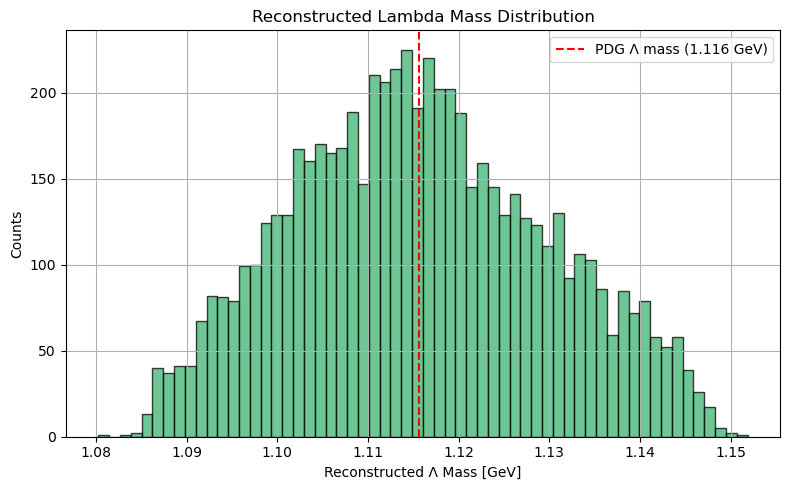

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute Reconstructed Lambda Mass (from 4-vector components) ---
# Formula: m² = E² - px² - py² - pz²
E = result_df["E_lam_reco"]
px = result_df["px_lam_reco"]
py = result_df["py_lam_reco"]
pz = result_df["pz_lam_reco"]

# Only keep valid (non-NaN) entries
valid = E.notna() & px.notna() & py.notna() & pz.notna()

# Calculate invariant mass
mass_squared = E[valid]**2 - (px[valid]**2 + py[valid]**2 + pz[valid]**2)
mass = np.sqrt(np.maximum(mass_squared, 0))  # ensure no negative under root

# --- Plot Histogram ---
plt.figure(figsize=(8, 5))
plt.hist(mass, bins=60, color="mediumseagreen", alpha=0.75, edgecolor="black")
plt.axvline(1.1156, color='red', linestyle='--', label="PDG Λ mass (1.116 GeV)")
plt.xlabel("Reconstructed Λ Mass [GeV]")
plt.ylabel("Counts")
plt.title("Reconstructed Lambda Mass Distribution")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


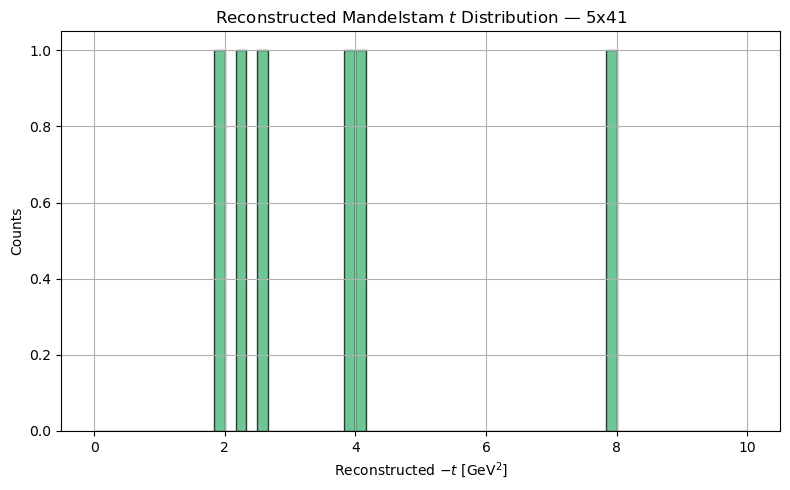

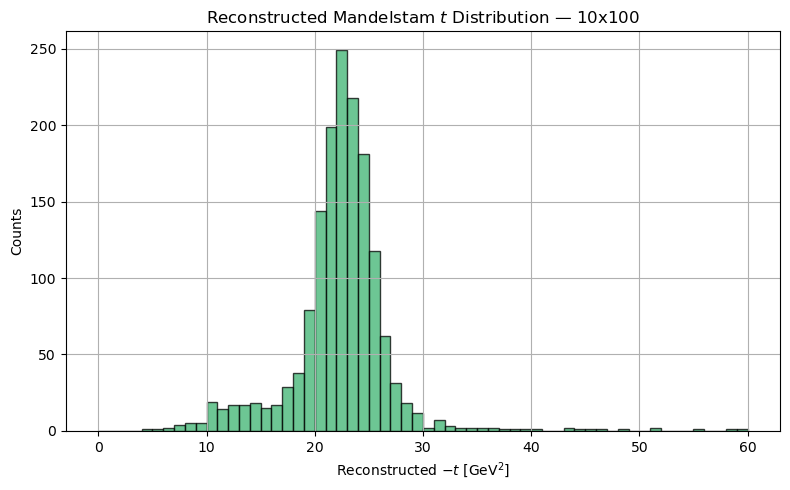

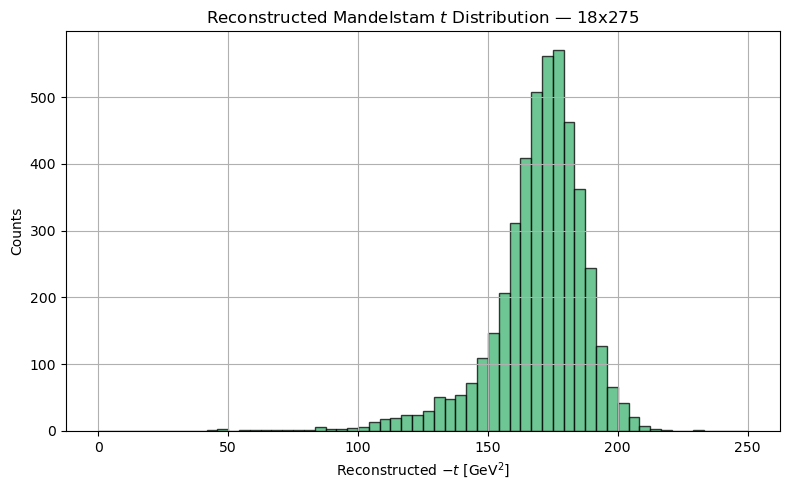

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Custom ranges per setting
t_ranges = {
    "5x41": (0, 10),
    "10x100": (0, 60),
    "18x275": (0, 250)
}

# Loop over each setting
for setting in result_df["setting"].unique():
    subset = result_df[(result_df["setting"] == setting) & result_df["t_reco"].notna()]
    t_vals = -subset["t_reco"]  # Flip sign if needed

    plt.figure(figsize=(8, 5))
    plt.hist(t_vals, bins=60, range=t_ranges[setting], color="mediumseagreen", alpha=0.75, edgecolor="black")
    plt.xlabel("Reconstructed $-t$ [GeV$^2$]")
    plt.ylabel("Counts")
    plt.title(f"Reconstructed Mandelstam $t$ Distribution — {setting}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"t_reco_hist_{setting}.png")
    plt.show()
